# Decoding stimulus identity from neural responses

We implement here a nearest-neighbor decoder of neural activity.

In [1]:
# general modules
import pynwb, os, sys, pprint, itertools
import numpy as np
import matplotlib.pylab as plt

# custom modules
sys.path.append('../physion')
from dataviz.show_data import MultimodalData, EpisodeResponse
from datavyz import graph_env_manuscript as ge

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

## Loading data and preprocessing

In [21]:
root_datafolder = os.path.join(os.path.expanduser('~'), 'UNPROCESSED')
filename = '2022_06_13-14-17-33.nwb'

episodes_NI = EpisodeResponse(os.path.join(root_datafolder, filename), 
                              quantities=['dFoF'],
                              protocol_id=1,
                              dt_sampling=30, # ms, to avoid to consume to much memory
                              verbose=True, prestim_duration=1.5)

print('episodes_NI:', episodes_NI.protocol_name)
print('varied parameters:', episodes_NI.varied_parameters)

NWB-file reading time: 582.5ms
  Number of episodes over the whole recording: 180/360 (with protocol condition)
  building episodes with 1 modalities [...]

calculating dF/F with method "maximin" [...]

  ** 4 ROIs were discarded with the positive F0 criterion (0.2%) ** 

-> dFoF calculus done !  (calculation took 1.1s)
  -> [ok] episodes ready !
episodes_NI: NI-VSE-3images-2vse-30trials
varied parameters: {'Image-ID': array([1., 2., 3.]), 'VSE-seed': array([6., 8.]), 'repeat': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}


In [8]:
episodes_GB = EpisodeResponse(os.path.join(root_datafolder, filename), 
                              protocol_id=0,
                              quantities=['dFoF'],
                              dt_sampling=30, # ms, to avoid to consume to much memory
                              verbose=True, prestim_duration=1.5)

print('episodes_GB:', episodes_GB.protocol_name)

NWB-file reading time: 771.7ms
  Number of episodes over the whole recording: 180/360 (with protocol condition)
  building episodes with 1 modalities [...]

calculating dF/F with method "maximin" [...]

  ** 4 ROIs were discarded with the positive F0 criterion (0.2%) ** 

-> dFoF calculus done !  (calculation took 1.1s)
  -> [ok] episodes ready !
episodes_GB: gaussian-blobs


## Visualizing evoked responses

In [3]:
def find_responsive_rois(episodes, stim_key,
                         value_threshold=0.5,
                         significance_threshold=0.05):
    
    responsive_rois = [[] for i in range(len(episodes.varied_parameters[stim_key]))]
    
    duration = episodes.data.metadata['Protocol-%i-presentation-duration' % (episodes.protocol_id+1)]

    # looping over neurons
    for roi in range(episodes.data.nROIs):
        roi_summary = episodes.compute_summary_data(dict(interval_pre=[-2,0], 
                                                         interval_post=[0,duration],
                                                         test='wilcoxon', 
                                                         positive=True),
                                                     response_args={'quantity':'dFoF', 
                                                                    'roiIndex':roi},
                                                   response_significance_threshold=significance_threshold)
        for istim, stim in enumerate(episodes.varied_parameters[stim_key]):
            if roi_summary['significant'][istim] and (roi_summary['value'][istim]>value_threshold):
                responsive_rois[istim].append(roi)
                
    return responsive_rois

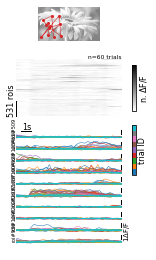

In [38]:
# let's pick a specific stim
stim_index = 1

def show_stim_evoked_resp(episodes, stim_key, stim_index,
                          quantity='dFoF',
                          responsive_rois = None,
                          value_threshold=0.5,
                          with_stim_inset=True,
                          Nrois=10):
    
    if responsive_rois is None:
        responsive_rois = np.arange(getattr(episodes, quantity).shape[1])
        
    return episodes.plot_evoked_pattern(episodes.find_episode_cond(stim_key, stim_index),
                                        rois=np.random.choice(responsive_rois, 
                                                         min([Nrois, len(responsive_rois)]), replace=False),
                                        quantity=quantity, with_stim_inset=with_stim_inset)

show_stim_evoked_resp(episodes_NI, 'Image-ID', 0);

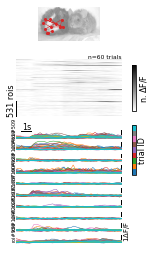

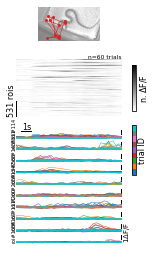

In [39]:
show_stim_evoked_resp(episodes_NI, 'Image-ID', 1);
show_stim_evoked_resp(episodes_NI, 'Image-ID', 2);

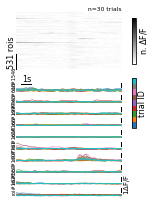

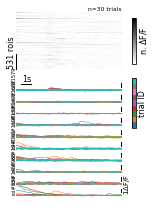

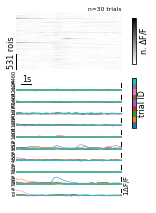

In [41]:
show_stim_evoked_resp(episodes_GB, 'center-time', 0, 
                      quantity='dFoF', with_stim_inset=False);
show_stim_evoked_resp(episodes_GB, 'center-time', 2, 
                      quantity='dFoF', with_stim_inset=False);
show_stim_evoked_resp(episodes_GB, 'center-time', 4, 
                      quantity='dFoF', with_stim_inset=False);

## Nearest-neighbor classifier for the classification of neural patterns

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

def run_model(episodes, key, values, seed=1, test_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split([episodes.dFoF[i,:,:].flatten() for i in range(episodes.dFoF.shape[0])],
                                                        values,
                                                        test_size=test_size, random_state=seed)
    #print(X_train.shape)
    nn_model = KNeighborsClassifier(n_neighbors=1, algorithm='brute').fit(X_train, y_train)
    y_predicted = nn_model.predict(X_test)
    return np.sum((y_predicted-y_test)==0)/len(y_test)

In [28]:
accuracies_NI = [run_model(episodes_NI, 
                           'Image-ID', 
                           getattr(episodes_NI, 'Image-ID'),
                           seed=i) for i in range(30)]

In [29]:
accuracies_GB = [run_model(episodes_GB, 
                           'center-time', 
                           np.array(10*getattr(episodes_GB, 'center-time'), dtype=int), 
                           seed=i) for i in range(30)]

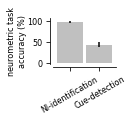

In [43]:
fig, ax = ge.bar([100*np.mean(accuracies_NI), 100*np.mean(accuracies_GB)],
       sy=[100*np.std(accuracies_NI), 100*np.std(accuracies_GB)])
ge.set_plot(ax, ylabel='neurometric task\naccuracy (%)', xticks=[0,1], 
            xticks_labels=['NI-identification', 'Cue-detection'],
            yticks=[0,50,100],
            xticks_rotation=30)